# Part B:

In [55]:
#importing all required libraries
import zipfile
import os
import shutil
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import pandas as pd 
import glob


from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
import matplotlib.pyplot as plt

# Data Loading and splitting

In [83]:
# Define the paths
extracted_path = 'dataset1/dataset'
train_path = 'dataset1/train'
test_path = 'dataset1/test'

os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Organize the dataset
categories = os.listdir(extracted_path)
for category in categories:
    category_full_path = os.path.join(extracted_path, category)
    if not os.path.isdir(category_full_path):
        continue
    
    # Create category directories in train and test folders
    os.makedirs(os.path.join(train_path, category), exist_ok=True)
    os.makedirs(os.path.join(test_path, category), exist_ok=True)
    
    # Get all image files in the category
    images = sorted(os.listdir(category_full_path))
    
    # Split the images into train (0001 to 0040) and test sets
    train_images = images[:40]
    test_images = images[40:]
    
    # Move train images
    for image in train_images:
        src = os.path.join(category_full_path, image)
        dst = os.path.join(train_path, category, image)
        shutil.move(src, dst)
        
    # Move test images
    for image in test_images:
        src = os.path.join(category_full_path, image)
        dst = os.path.join(test_path, category, image)
        shutil.move(src, dst)

print("Dataset organized into training and testing sets.")


Dataset organized into training and testing sets.


# Data Augumentation

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 600 images belonging to 15 classes.
Found 205 images belonging to 15 classes.


# Fine Tuning VGG-19 Model 

In [23]:

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(15, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])


# Training

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint('vgg19_best.keras', monitor='val_accuracy', save_best_only=True)
early_stopping = EarlyStopping(patience=10)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/50


C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 285s 16s/step - Precision: 0.5263 - Recall: 0.0012 - accuracy: 0.1332 - loss: 2.6106 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5677 - val_loss: 1.8578
Epoch 2/50
 1/18 ━━━━━━━━━━━━━━━━━━━━ 3:27 12s/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.2812 - loss: 2.0875

C:\Users\Admin\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 304ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.2812 - loss: 2.0875 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.3846 - val_loss: 2.0832
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 326s 18s/step - Precision: 0.8947 - Recall: 0.0624 - accuracy: 0.5213 - loss: 1.8036 - val_Precision: 1.0000 - val_Recall: 0.1927 - val_accuracy: 0.7656 - val_loss: 1.2603
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 364ms/step - Precision: 1.0000 - Recall: 0.0625 - accuracy: 0.6250 - loss: 1.5144 - val_Precision: 1.0000 - val_Recall: 0.3077 - val_accuracy: 0.7692 - val_loss: 1.0555
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 321s 18s/step - Precision: 1.0000 - Recall: 0.2317 - accuracy: 0.6848 - loss: 1.2658 - val_Precision: 0.8889 - val_Recall: 0.3750 - val_accuracy: 0.6771 - val_loss: 1.0330
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 343ms/step - Precision: 0.9000 - Recall: 0.2812 - accuracy: 0.5000 - loss: 1.3789 - val_Precision: 1.0000 - val

# Evaluation on Test Images

In [81]:
def predict_and_show_images(test_path, model, num_images=6):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i in range(num_images):
        # Choose a random category
        category = random.choice(os.listdir(test_path))
        category_path = os.path.join(test_path, category)

        # Choose a random image file from that category
        image_file = random.choice(os.listdir(category_path))
        image_path = os.path.join(category_path, image_file)

        # Load and preprocess the image
        image = load_img(image_path, target_size=(224, 224))
        image_array = img_to_array(image)
        image_array = image_array / 255.0  # Rescale as done in the ImageDataGenerator
        image_array = np.expand_dims(image_array, axis=0)  # Expand dims to fit model input

        # Predict the image
        predictions = model.predict(image_array)
        predicted_class = np.argmax(predictions, axis=1)

        # Retrieve the actual label (the category)
        actual_label = category

        # Find predicted label name from class index
        labels = (train_generator.class_indices)
        labels = dict((v, k) for k, v in labels.items())
        predicted_label = labels[predicted_class[0]]

        # Plotting
        ax = axes[i]
        ax.imshow(np.squeeze(image))
        ax.set_title(f"Pred: {predicted_label}\nActual: {actual_label}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


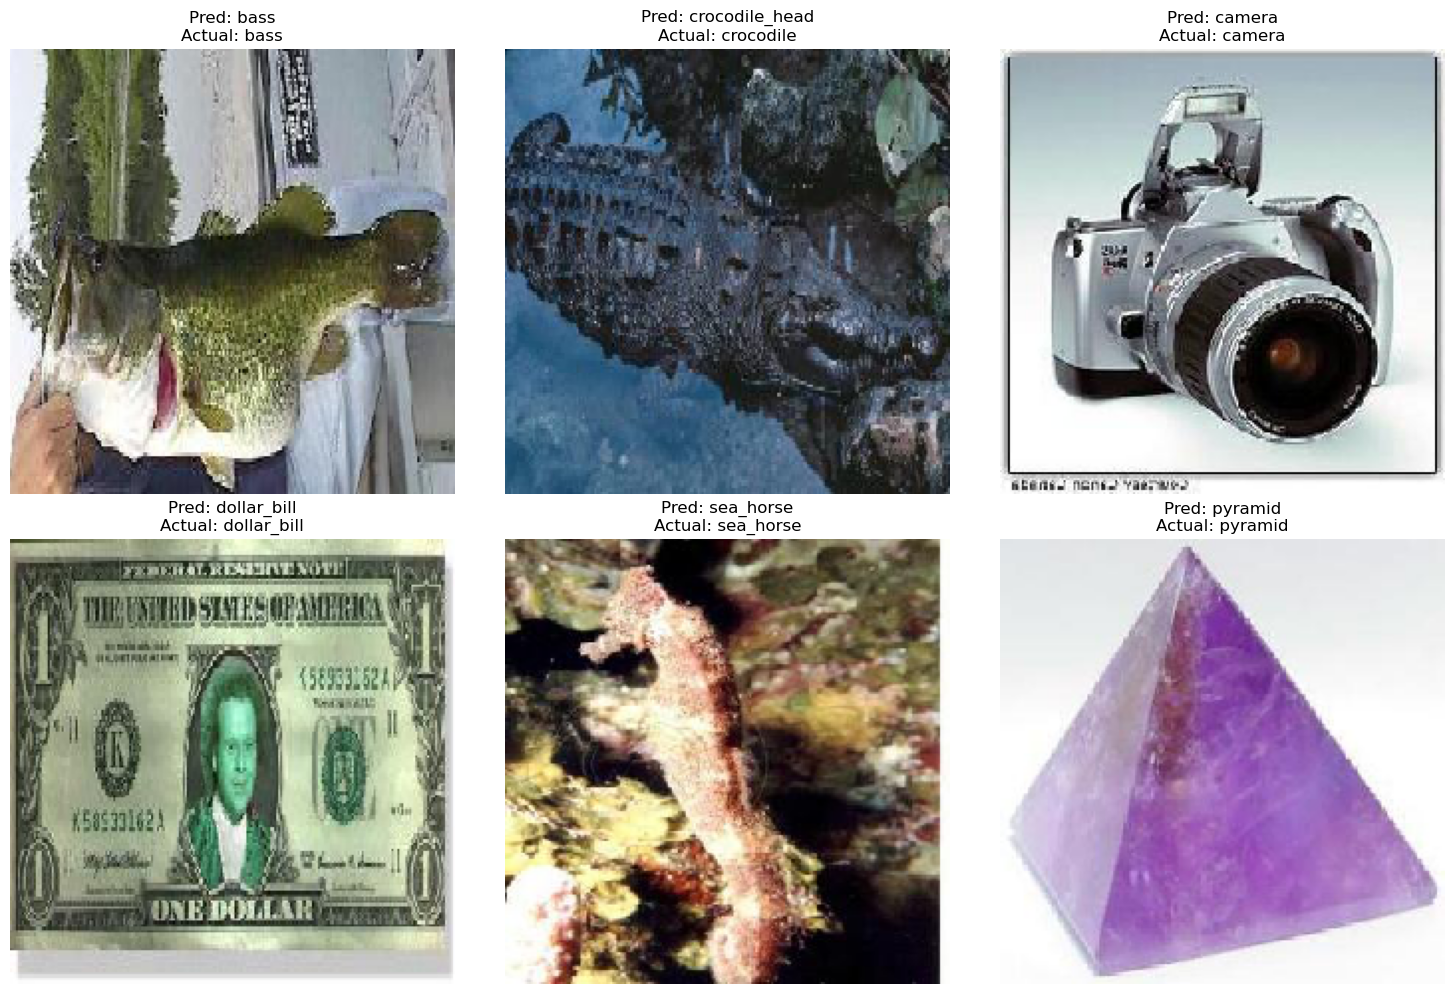

In [84]:
predict_and_show_images(test_path, model)

In [43]:
model.summary() #Model Summary

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,646,447 (82.57 MB)

 Trainable params: 540,687 (2.06 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

 Optimizer params: 1,081,376 (4.13 MB)

# Testing On Unseen Image

In [95]:
image_path = "C:\\Users\\Admin\\Downloads\\download (2).jpg" #Unseen Image

In [85]:
def predict_single_image(image_path, model):
    # Load and preprocess the image
    image = load_img(image_path, target_size=(224, 224))
    image_array = img_to_array(image)
    image_array = image_array / 255.0  # Rescale as done in the ImageDataGenerator
    image_array = np.expand_dims(image_array, axis=0)  # Expand dims to fit model input

    # Predict the image
    predictions = model.predict(image_array)
    predicted_class = np.argmax(predictions, axis=1)

    # Find predicted label name from class index
    labels = (train_generator.class_indices)
    labels = dict((v, k) for k, v in labels.items())
    predicted_label = labels[predicted_class[0]]

    # Display the image and prediction
    plt.imshow(image.resize((224, 224)))
    plt.title(f"Predicted Label: {predicted_label}")
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


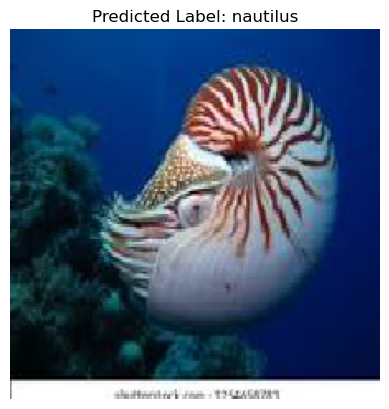

In [96]:
predict_single_image(image_path, model)

In [92]:
model.save('Vgg19_finetuned_model.h5')

Inferences: 

•	Observed accuracy, precision, and recall improved over a few epochs. Initially, they were low, but the accuracy, precision, and recall increased over the few epochs and iterations. 

•	Early stopping in the code was used to stop the model when it started to overfit.

•	Finally got a test accuracy of 92%, a precision of 91%, and a recall of 84%. This shows the model is able to identify true positives correctly. 

•	The loss of the model was high initially, but over the epochs, it was reduced significantly in the final epochs, which is a 33% loss in the final epochs. This shows the efficiency of the model.
